## Import and Data Initialisation

In [6]:
import xarray as xr
import pandas as pd
import rasterio
import os
from rasterio.mask import mask
from rasterio.transform import from_bounds
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', True)
pd.set_option('large_repr','truncate')
pd.set_option('display.width', 1000)

In [7]:
from data_creation import download_data
download_data()
# If it doesn't work just download it and put the data folder in the root folder of the repository

Data folder already exists at :  c:\Users\Alec\Desktop\Github Repositories\GenHack-Team28\data


In [5]:
current_working_dir = os.getcwd()
project_root = os.path.dirname(current_working_dir)
main_data_folder = os.path.join(project_root, "data")

era5_data_folder = os.path.join(main_data_folder, "derived-era5-land-daily-statistics")
ndvi_data_folder = os.path.join(main_data_folder, "sentinel2_ndvi")
eca_tx_datafolder = os.path.join(main_data_folder, "ECA_blend_tx")

gadm_filepath = os.path.join(main_data_folder, "gadm_410_europe.gpkg")
stations_filepath = os.path.join(eca_tx_datafolder, "stations.txt")

# Administration geometries from GADM

[GADM](https://gadm.org/) provides maps and spatial data for all countries and their sub-divisions. Here is a light version limited to European countries.

We decided to focus on Lyon, in France.

## Parametrize and Initialize

In [8]:
country_code = "FRA"
cityname = "Lyon"

In [9]:
gadm_gdf = gpd.read_file(gadm_filepath)

In [10]:
country_gdf = gadm_gdf[gadm_gdf.GID_0 == country_code]

## Manipulate and vizualize

In [11]:
country_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 36611 entries, 15270 to 51880
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   UID        36611 non-null  int64   
 1   GID_0      36611 non-null  object  
 2   NAME_0     36611 non-null  object  
 3   GID_1      36611 non-null  object  
 4   NAME_1     36611 non-null  object  
 5   ENGTYPE_1  36611 non-null  object  
 6   GID_2      36611 non-null  object  
 7   NAME_2     36611 non-null  object  
 8   ENGTYPE_2  36611 non-null  object  
 9   GID_3      36611 non-null  object  
 10  NAME_3     36611 non-null  object  
 11  ENGTYPE_3  36611 non-null  object  
 12  GID_4      36611 non-null  object  
 13  NAME_4     36611 non-null  object  
 14  ENGTYPE_4  36611 non-null  object  
 15  GID_5      36611 non-null  object  
 16  NAME_5     36611 non-null  object  
 17  ENGTYPE_5  36611 non-null  object  
 18  COUNTRY    36611 non-null  object  
 19  CONTINENT  36611 n

We can see there are five administrative levels (NAME_i), so we need to find out the one corresponding to Lyon :

In [12]:
for i in range(1, 6):
    name_col = f'NAME_{i}'
    if name_col in country_gdf.columns:
        lyon_in_col = country_gdf[country_gdf[name_col] == cityname]
        if not lyon_in_col.empty:
            print(f"'{cityname}' found in {name_col}. Example: {lyon_in_col[name_col].iloc[0]}")
        else:
            print(f"'{cityname}' not found in {name_col}.")

'Lyon' not found in NAME_1.
'Lyon' not found in NAME_2.
'Lyon' found in NAME_3. Example: Lyon
'Lyon' not found in NAME_4.
'Lyon' not found in NAME_5.


In [ ]:
# List of Lyon arrondisments
lyon_arrondissements = [ "Lyon, 1er arrondissement",
                          "Lyon, 2e arrondissement",
                         "Lyon, 3e arrondissement",
                         "Lyon, 4e arrondissement",
                         "Lyon, 5e arrondissement",
                         "Lyon, 6e arrondissement",
                         "Lyon, 7e arrondissement",
                         "Lyon, 8e arrondissement",
                         "Lyon, 9e arrondissement" ]
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == "FRA") & (gadm_gdf.NAME_5.isin(lyon_arrondissements))]

In [12]:
print(f"Number of rows in GADM after filtering: {len(filtered_gadm_gdf)}")
filtered_gadm_gdf

Number of rows in GADM after filtering: 9


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
18920,59279,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.10_1,"Lyon, 1er arrondissement",Canton,FRA.1.11.1.10.1_1,"Lyon, 1er arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.83976 45.76627, 4.83049 45.7..."
18921,59280,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.11_1,"Lyon, 2e arrondissement",Canton,FRA.1.11.1.11.1_1,"Lyon, 2e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.83049 45.76471, 4.83976 45.7..."
18922,59281,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.12_1,"Lyon, 3e arrondissement",Canton,FRA.1.11.1.12.1_1,"Lyon, 3e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.89901 45.75246, 4.89229 45.7..."
18923,59282,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.13_1,"Lyon, 4e arrondissement",Canton,FRA.1.11.1.13.1_1,"Lyon, 4e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.81917 45.78959, 4.8254 45.78..."
18924,59283,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.14_1,"Lyon, 5e arrondissement",Canton,FRA.1.11.1.14.1_1,"Lyon, 5e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.8197 45.76715, 4.82823 45.76..."
18925,59284,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.15_1,"Lyon, 6e arrondissement",Canton,FRA.1.11.1.15.1_1,"Lyon, 6e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.84305 45.77861, 4.85148 45.7..."
18926,59285,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.16_1,"Lyon, 7e arrondissement",Canton,FRA.1.11.1.16.1_1,"Lyon, 7e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.84055 45.70805, 4.82305 45.7..."
18927,59286,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.17_1,"Lyon, 8e arrondissement",Canton,FRA.1.11.1.17.1_1,"Lyon, 8e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.89229 45.73902, 4.88699 45.7..."
18928,59287,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.18_1,"Lyon, 9e arrondissement",Canton,FRA.1.11.1.18.1_1,"Lyon, 9e arrondissement",Commune,France,Europe,"MULTIPOLYGON (((4.84148 45.80344, 4.81917 45.7..."


In [13]:
one_city_gdf = filtered_gadm_gdf.dissolve()
one_city_gdf.head()

,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT
0,"POLYGON ((4.81897 45.72509, 4.8133 45.74017, 4...",59279,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,Region,FRA.1.11_1,Rhône,Department,FRA.1.11.1_1,Lyon,Districts,FRA.1.11.1.10_1,"Lyon, 1er arrondissement",Canton,FRA.1.11.1.10.1_1,"Lyon, 1er arrondissement",Commune,France,Europe


<Axes: >

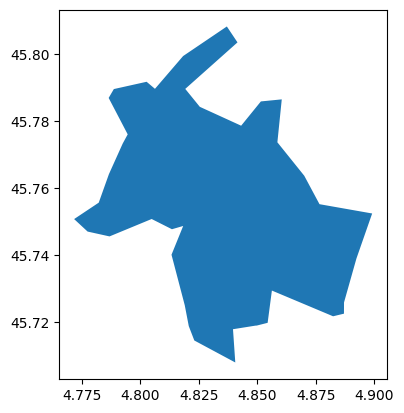

In [14]:
one_city_gdf.plot()

# ERA5-Land Meteorological data (frequency = daily)

ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5.

The data, processed on a daily temporal resolution, originally stems from a public hourly dataset: [ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview) on the [Climate Data Store](https://cds.climate.copernicus.eu/).

The available land variables are:
- Daily maximum of hourly [2 metre temperature](https://apps.ecmwf.int/codes/grib/param-db/167) in Kelvin,
- Daily mean of hourly [total precipitation](https://apps.ecmwf.int/codes/grib/param-db/228) in meters,
- Daily mean of hourly [10 metre U wind component](https://apps.ecmwf.int/codes/grib/param-db/165) in meters per second,
- Daily mean of hourly [10 metre V wind component](https://apps.ecmwf.int/codes/grib/param-db/166) in meters per second.

In [15]:
variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}

## Parametrize

In [16]:
variable = "2m_temperature"
year = 2024

In [17]:
statistic = variable2statistic[variable]
datavar = variable2datavar[variable]

## Manipulate and vizualize

Please open the [xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/index.html) to see how to manipulate the data (especially in the "Core operations" chapter).

Here are a few examples of operations:

### One dataset

In [18]:
filepath = f"{era5_data_folder}/{year}_{variable}_{statistic}.nc"

In [19]:
ds = xr.open_dataset(filepath)

In [52]:
ds

<xarray.Dataset> Size: 338MB
Dimensions:      (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 3kB 2024-01-01 ... 2024-12-31
  * latitude     (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude    (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number       int64 8B ...
    spatial_ref  int64 8B 0
Data variables:
    t2m          (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-04T13:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [66]:
#POINT (5.07778 45.72639)
lat, lon = 4.825, 45.76#45.72639, 5.07778 #4.8133 45.74017

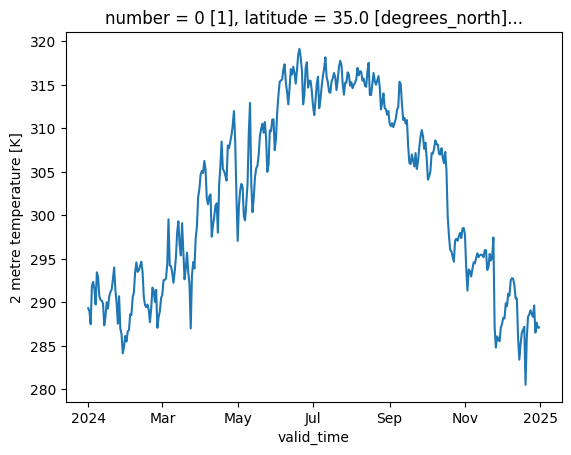

In [67]:
ds[datavar].sel(latitude=lat, longitude=lon, method="nearest").plot()

In [68]:
day = pd.to_datetime(f"{year}-06-01")

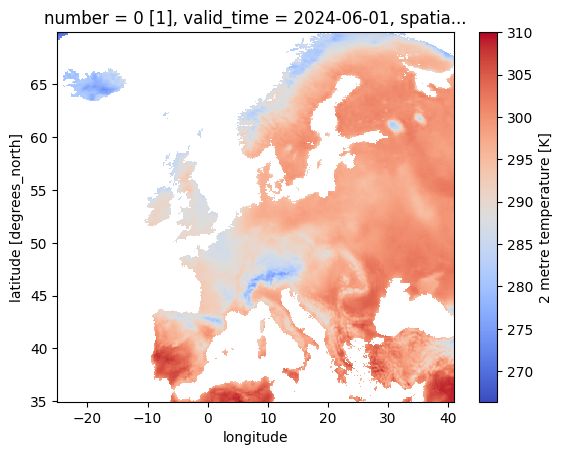

In [69]:
ds[datavar].sel(valid_time=day).plot(cmap='coolwarm')

Again, we will focus on Lyon. In order to use the polygon we got earlier, we will use rioxarray. So first, we have to make the CRS the same.

https://corteva.github.io/rioxarray/stable/examples/clip_geom.html

In [70]:
if (ds.rio.crs == None):
  ds.rio.write_crs(one_city_gdf.crs, inplace=True)

print(f"CRS of the gdf : {one_city_gdf.crs}")
print(f"CRS of the xarray : {ds.rio.crs}")

CRS of the gdf : EPSG:4326
CRS of the xarray : EPSG:4326


In [39]:
clipped = ds.rio.clip(one_city_gdf.geometry, one_city_gdf.crs, drop=True)

In [71]:
one_city_gdf['geometry']

,geometry
0,"POLYGON ((4.81897 45.72509, 4.8133 45.74017, 4..."


In [72]:
clipped = ds.rio.clip(one_city_gdf['geometry'], drop=True)

NoDataInBounds: No data found in bounds. Data variable: t2m

In [ ]:
clipped[datavar].sel(valid_time=day).plot(cmap='coolwarm')

### Multiple datasets

In [73]:
#Added 202[0-9] to chain all the yearly files related to variable and statistic
filepaths = glob(f"{era5_data_folder}/202[0-9]_{variable}_{statistic}.nc")


In [ ]:
ds = xr.open_mfdataset(filepaths, combine="by_coords")
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

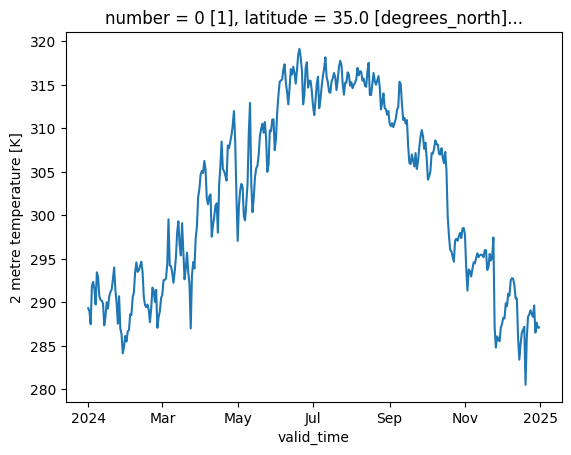

In [74]:
ds[datavar].sel(latitude=lat, longitude=lon, method="nearest").plot()

In [75]:
kelvin_to_celsius = lambda x:x-273.15
era5_df=ds['t2m'].sel(latitude=lat, longitude=lon, method="nearest").to_dataframe()
era5_df['Celsius']=era5_df['t2m'].map(kelvin_to_celsius)
era5_df.describe()

,number,latitude,longitude,spatial_ref,t2m,Celsius
count,366.0,3.660000e+02,3.660000e+02,366.0,366.000000,366.000000
mean,0.0,3.500000e+01,4.090000e+01,0.0,302.048035,28.898029
std,0.0,1.992243e-13,2.134546e-13,0.0,10.475947,10.475949
min,0.0,3.500000e+01,4.090000e+01,0.0,280.505249,7.355249
25%,0.0,3.500000e+01,4.090000e+01,0.0,292.639816,19.489816
50%,0.0,3.500000e+01,4.090000e+01,0.0,302.625092,29.475092
75%,0.0,3.500000e+01,4.090000e+01,0.0,312.171326,39.021326
max,0.0,3.500000e+01,4.090000e+01,0.0,319.157227,46.007227


In [76]:
if 'ds' in locals():
     del ds
     gc.collect()

print("Memory management tips applied.")

Memory management tips applied.


# Normalized Difference Vegetation Index from Sentinel-2 (frequency = every 3 months)

The Normalized difference vegetation index (known as NDVI) is a simple, but effective index for quantifying green vegetation. Its values range from -1 to 1. More details on [sentinelhub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/).

In [77]:
def quarter2timeperiod(year, quarter):
    if quarter == 1:
        return f"{year-1}-12-01_{year}-03-01"
    elif quarter == 2:
        return f"{year}-03-01_{year}-06-01"
    elif quarter == 3:
        return f"{year}-06-01_{year}-09-01"
    elif quarter == 4:
        return f"{year}-09-01_{year}-12-01"
    else:
        raise ValueError("quarter must be in 1, 2, 3, 4")

## Parametrize

In [78]:
available_years = [2020, 2021, 2022, 2023]
available_quarters = [1, 2, 3, 4]

In [79]:
year = 2021
quarter = 1

In [80]:
timeperiod = quarter2timeperiod(year, quarter)

filepath  = f"{ndvi_data_folder}/ndvi_{timeperiod}.tif"

## Manipulate and vizualize

In [85]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

In [84]:
real_out_image, out_meta = get_out_image_and_metadata(filepath, one_city_gdf)

TypeError: 'numpy.ndarray' object is not callable

In [83]:
plt.figure()
plt.imshow(real_out_image[0], cmap='Greens', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"NDVI over {cityname} during {timeperiod}")
plt.axis('off')
plt.show()

NameError: name 'real_out_image' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
mean_ndvi = np.nanmean(real_out_image[0])
print(f"Mean NDVI over {cityname} during {timeperiod}: {mean_ndvi:.3f}")

Mean NDVI over Lyon during 2020-12-01_2021-03-01: 0.497


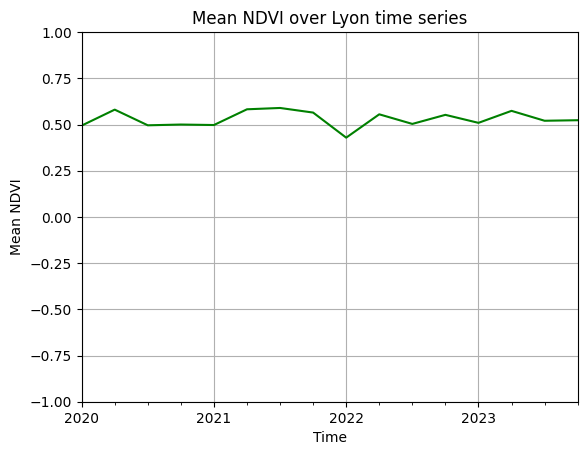

In [ ]:
mean_ndvi_time_series = pd.Series(dtype=float)
for year in available_years:
    for quarter in available_quarters:
        timeperiod = quarter2timeperiod(year, quarter)
        filepath  = f"{ndvi_data_folder}/ndvi_{timeperiod}.tif"
        date = pd.to_datetime(timeperiod.split("_")[1])
        current_real_out_image, _ = get_out_image_and_metadata(filepath, one_city_gdf)
        current_mean_ndvi = np.nanmean(current_real_out_image[0])
        mean_ndvi_time_series.loc[date] = current_mean_ndvi

mean_ndvi_time_series = mean_ndvi_time_series.sort_index()

plt.figure()
mean_ndvi_time_series.plot(color='green')
plt.title(f"Mean NDVI over {cityname} time series")
plt.ylabel("Mean NDVI")
plt.xlabel("Time")
plt.ylim(-1, 1)
plt.grid()
plt.show()

In [ ]:
# Or after processing an NDVI image:
if 'real_out_image' in locals():
  del real_out_image
  gc.collect()
print("Memory management tips applied.")

## Reproject ERA5-Land features on the NDVI grid

In [ ]:
ds = xr.open_mfdataset(filepaths, combine="by_coords") # Re-load ds
da = ds[datavar].sel(valid_time=day)
da

<xarray.DataArray 't2m' (latitude: 350, longitude: 660)> Size: 924kB
dask.array<getitem, shape=(350, 660), dtype=float32, chunksize=(22, 42), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
    valid_time  datetime64[ns] 8B 2024-06-01
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [ ]:
origin_transform = from_bounds(
    ds.longitude.min().item(),
    ds.latitude.min().item(),
    ds.longitude.max().item(),
    ds.latitude.max().item(),
    len(ds.longitude),
    len(ds.latitude)
)
origin_crs = "EPSG:4326"

target_transform = out_meta["transform"]
target_crs = out_meta["crs"]

In [ ]:
reprojected_da = da.rio.write_crs(origin_crs).rio.reproject(
    dst_crs=target_crs,
    shape=(out_meta["height"], out_meta["width"]),
    transform=target_transform,
)

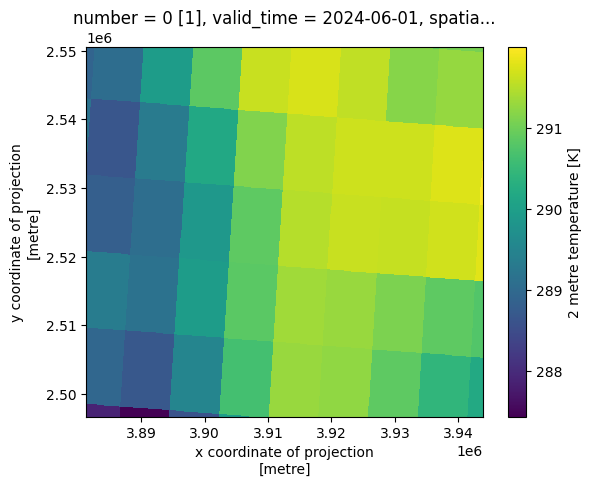

In [ ]:
reprojected_da.plot()

# Blended European Climate Assessment datasets

The data stems from the [European Climate Assessment & Dataset project website](https://www.ecad.eu/dailydata/predefinedseries.php).

The example dataset is "Daily maximum temperature TX" (ie. `ECA_blend_tx`).

In [ ]:
eca_tx_datafolder = main_data_folder + "/ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"
print(stations_filepath)

/content/drive/MyDrive/GenHack-Team28/data/ECA_blend_tx/stations.txt


## Filter weather stations

In [ ]:
def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()

    sign = 1 if dms_str[0] == '+' else -1

    dms_str = dms_str[1:]

    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])

    decimal = sign * (degrees + minutes/60 + seconds/3600)

    return decimal

In [ ]:
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

print(f"Number of registered stations: {len(stations_gdf)}")
stations_gdf.head()

Number of registered stations: 8568


,STAID,STANAME,CN,HGHT,geometry
0,1,VAEXJOE,SE,166,POINT (14.8 56.86667)
1,2,FALUN,SE,160,POINT (15.61667 60.61667)
2,3,STENSELE,SE,325,POINT (17.16639 65.06667)
3,4,LINKOEPING,SE,93,POINT (15.53306 58.4)
4,5,LINKOEPING-MALMSLAETT,SE,93,POINT (15.53306 58.4)


In [ ]:
one_city_gdf.to_crs(stations_gdf.crs, inplace=True) # Use same CRS for spatial operations

stations_in_city_gdf = stations_gdf[stations_gdf.within(one_city_gdf.geometry.iloc[0])]

print(f"Number of registered stations within {cityname}: {len(stations_in_city_gdf)}")
stations_in_city_gdf.head()

Number of registered stations within Lyon: 1


,STAID,STANAME,CN,HGHT,geometry
31,37,LYON - ST EXUPERY,FR,235,POINT (5.07778 45.72639)


## Manipulate and vizualize

In [ ]:
# Select a station to study
selected_station = stations_in_city_gdf.iloc[0]

In [ ]:
selected_station_gdf = gpd.GeoDataFrame([selected_station], crs=stations_in_city_gdf.crs)
selected_station_STAID = selected_station['STAID']

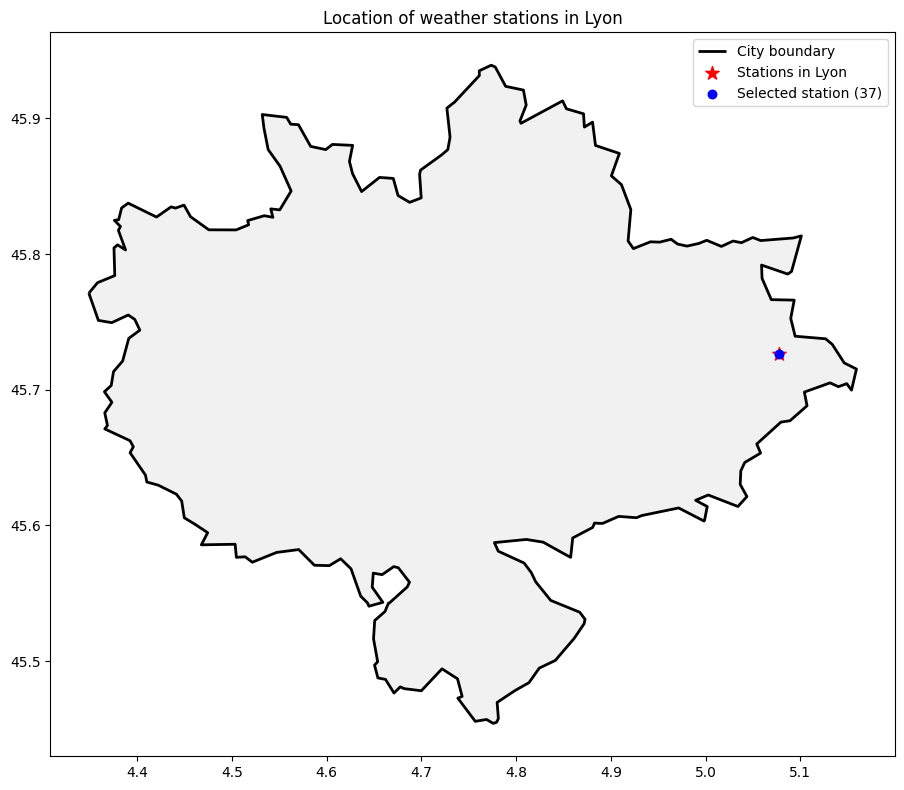

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

one_city_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='City boundary')
one_city_gdf.plot(ax=ax, alpha=0.3, color='lightgray')

stations_in_city_gdf.plot(ax=ax, color='red', markersize=100, marker='*', label=f'Stations in {cityname}')
selected_station_gdf.plot(ax=ax, color='blue', markersize=150, marker='.', label=f'Selected station ({selected_station_STAID})')

plt.legend()
plt.title(f"Location of weather stations in {cityname}")
plt.tight_layout()
plt.show()

In [ ]:
station_data_filepath = eca_tx_datafolder + f"TX_STAID{selected_station_STAID:06d}.txt"

In [ ]:
station_data_df = pd.read_csv(
    station_data_filepath,
    skiprows=20,
    skipinitialspace=True
)

valid_data_df = station_data_df[station_data_df['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
valid_data_df['DATE'] = pd.to_datetime(valid_data_df['DATE'], format='%Y%m%d')
valid_data_df['TX_celsius'] = valid_data_df['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

tx_timeseries = pd.Series(
    valid_data_df['TX_celsius'].values,
    index=valid_data_df['DATE']
)

print(f"Number of valid daily records for station {selected_station_STAID}: {len(tx_timeseries)}")

Number of valid daily records for station 37: 18397


In [ ]:
print(valid_data_df['TX_celsius'].describe(),era5_df['Celsius'].describe())

count    18397.000000
mean        16.840278
std          8.783092
min        -12.200000
25%         10.300000
50%         16.900000
75%         23.600000
max         39.900000
Name: TX_celsius, dtype: float64 count    2098.000000
mean       17.603183
std         8.194074
min         1.201196
25%        11.117418
50%        17.238519
75%        23.532648
max        38.813379
Name: Celsius, dtype: float64


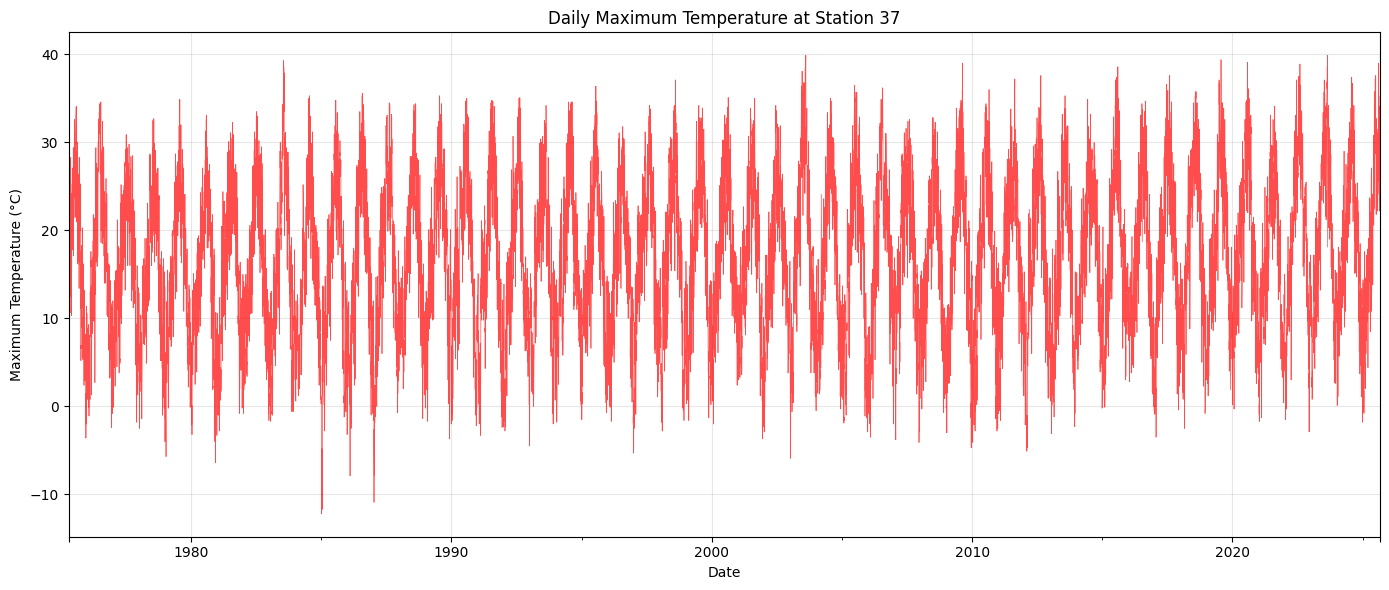

In [ ]:
plt.figure(figsize=(14, 6))
tx_timeseries.plot(color='red', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature at Station {selected_station_STAID}")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

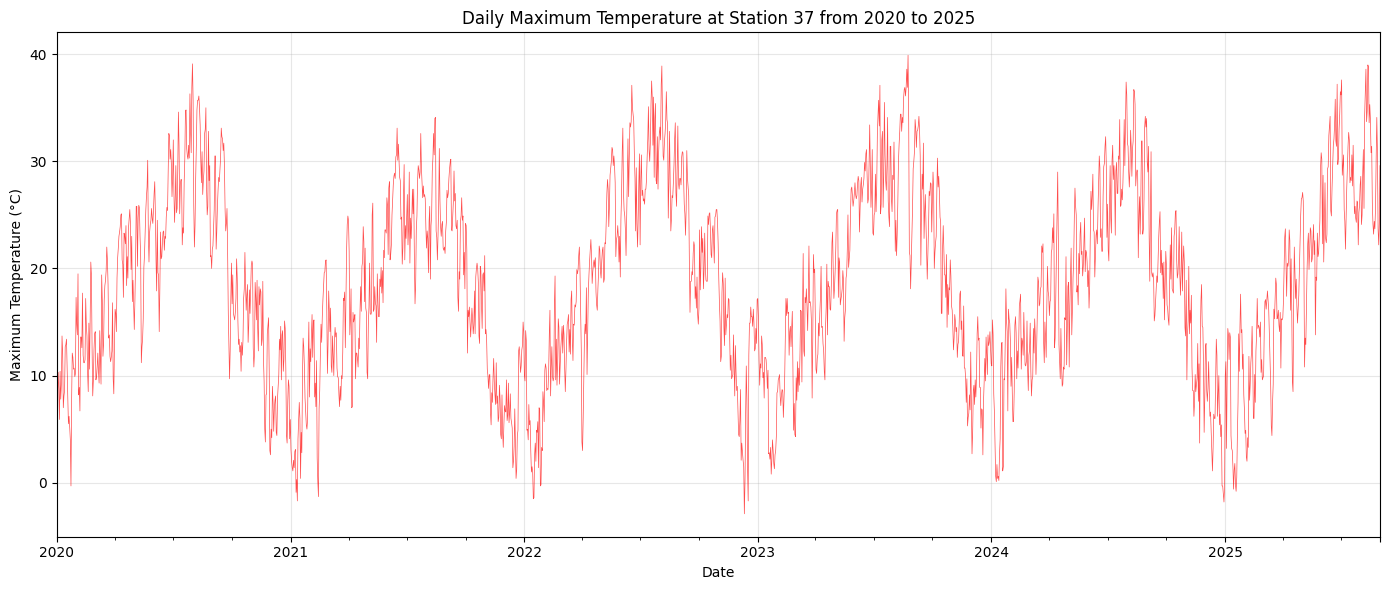

In [ ]:
start = "2020-01-01"
end = "2025-08-31"
plt.figure(figsize=(14, 6))
tx_timeseries.loc[start:end].plot(color='red', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature at Station {selected_station_STAID} from 2020 to 2025")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

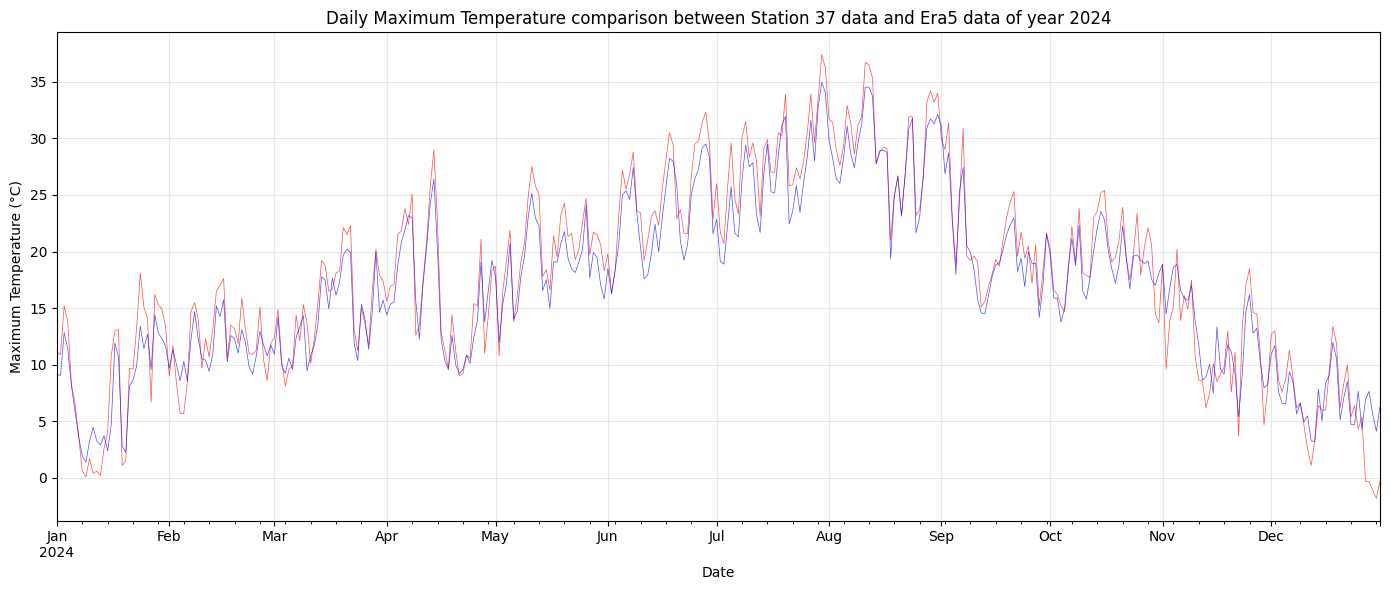

In [ ]:
start = "2024-01-01"
end = "2024-12-31"
plt.figure(figsize=(14, 6))
tx_timeseries.loc[start:end].plot(color='red', linewidth=0.5, alpha=0.7)
era5_df['Celsius'].loc[start:end].plot(color='blue', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature comparison between Station {selected_station_STAID} data and Era5 data of year 2024")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

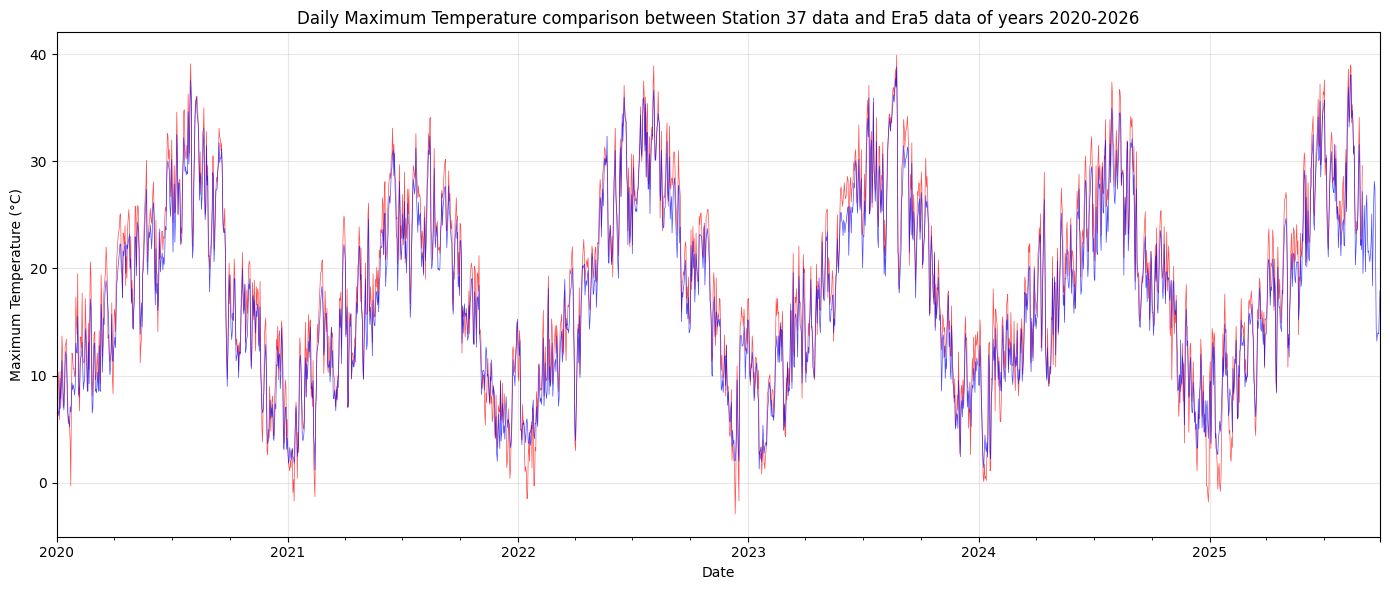

In [ ]:
start = "2020-01-01"
end = "2026-11-01"
plt.figure(figsize=(14, 6))
tx_timeseries.loc[start:end].plot(color='red', linewidth=0.5, alpha=0.7)
era5_df['Celsius'].loc[start:end].plot(color='blue', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature comparison between Station {selected_station_STAID} data and Era5 data of years 2020-2026")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import sys
import os
explorations_filepath = os.path.join(main_data_folder, "../stations_exploration.py")
explorations_filepath = os.path.abspath(explorations_filepath)

print(explorations_filepath)
module_dir = os.path.dirname(explorations_filepath)
sys.path.append(module_dir)

/content/drive/MyDrive/GenHack-Team28/stations_exploration.py


Stations within Lyon: 1


,STAID,STANAME,CN,HGHT,start_year,end_year,overall_completeness_%,years_count
0,37,None,FR,235,1975,2025,99.896829,51


Overall completeness: 99.9%


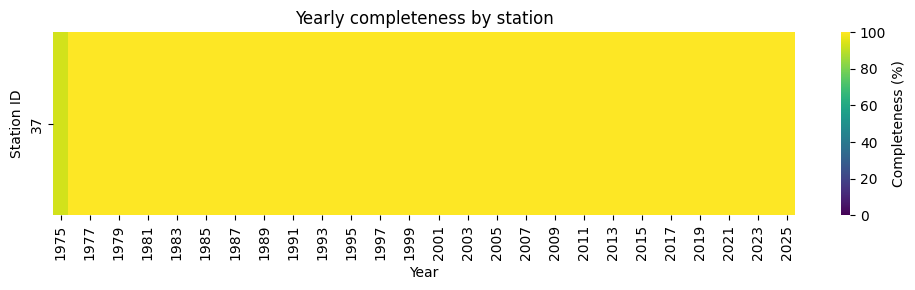

In [ ]:
from stations_exploration import *

# 1) Load metadata and select Lyon
stations_gdf = load_stations_metadata(stations_filepath)
lyon_stations = filter_stations_by_polygon(stations_gdf, one_city_gdf)
print(f"Stations within {cityname}: {len(lyon_stations)}")

# 2) Build summary for all Lyon stations
summary = summarize_city_stations(lyon_stations, eca_tx_datafolder)
display(summary)

# 3) Interactive map
fmap = make_folium_map(lyon_stations, summary)
fmap  # in Colab, shows interactive map

# 4) Pick best station by completeness
best_id = int(summary.iloc[0]["STAID"])
ts = read_station_tx_series(best_id, eca_tx_datafolder)

overall, per_year = compute_completeness(ts)
print(f"Overall completeness: {overall:.1f}%")
plot_completeness_heatmap({best_id: per_year})